In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Training / Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [2]:
# Loading Data
dataset_path = 'datasets/UCI HAR Dataset/'

In [3]:
# Load feature names
features = pd.read_csv(f'{dataset_path}features.txt', sep='\s+', names=['feature_id', 'feature_name'])
feature_names = features['feature_name']

# Creating a unique name for "duplicate" feature names (example: fBodyAcc-bandsEnergy()-1,8 )
name_count = {}
unique_feature_names = []

for name in feature_names:
    if name in name_count:
        name_count[name] += 1
        unique_feature_names.append(f"{name}_{name_count[name]}")
    else:
        name_count[name] = 0
        unique_feature_names.append(name)

In [4]:
# Loading training data
X_train = pd.read_csv(f'{dataset_path}train/X_train.txt', sep='\s+', names=unique_feature_names)
y_train = pd.read_csv(f'{dataset_path}train/y_train.txt', sep='\s+', names=['Activity'])

# Loading testing data
X_test = pd.read_csv(f'{dataset_path}test/X_test.txt', sep='\s+', names=unique_feature_names)
y_test = pd.read_csv(f'{dataset_path}test/y_test.txt', sep='\s+', names=['activity'])

In [5]:
y_train.head()

Activity
0         5
1         5
2         5
3         5
4         5

In [6]:
X_train.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyroJerkMag-meanFreq()  \
0         -0.923527         -0.934724  ...                        -0.074323   
1         -0.957686         -0.943068  ...                         0.158075   
2         -0.977469         -0.938692  ...                         0.414503   
3         -0.989302         -0.938692  ...                         0.404573   
4         -0.990441         -0.942469  ...                         0.087753   

   fBodyBodyGyroJerkMag-skewness()  fBodyBodyGyroJerkMag-kurtosis()  \
0                        -0.298676                        -0.710304   
1                        -0.595051                        -0.861499   
2                        -0.390748                        -0.760104   
3                        -0.117290                        -0.482845   
4                        -0.351471                        -0.699205   

   angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
0                    -0.112754                              0.030400   
1                     0.053477                             -0.007435   
2                    -0.118559                              0.177899   
3                    -0.036788                             -0.012892   
4                     0.123320                              0.122542   

   angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
0                         -0.464761                             -0.018446   
1                         -0.732626                              0.703511   
2                          0.100699                              0.808529   
3                          0.640011                             -0.485366   
4                          0.693578                             -0.615971   

   angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  
0             -0.841247              0.179941             -0.058627  
1             -0.844788              0.180289             -0.054317  
2             -0.848933              0.180637             -0.049118  
3             -0.848649              0.181935             -0.047663  
4             -0.847865              0.185151             -0.043892  

[5 rows x 561 columns]

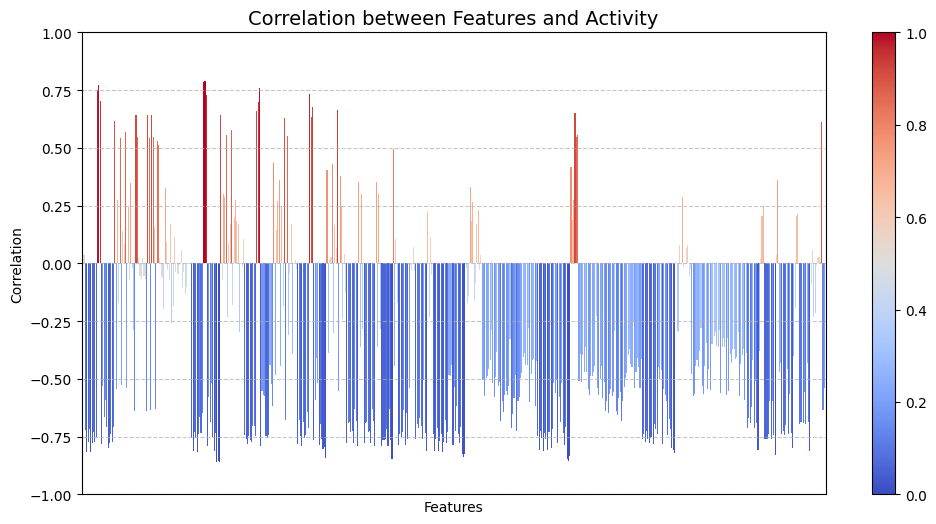

In [7]:
# Feature Selection
feature_correlations = X_train.corrwith(y_train['Activity'])

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(feature_correlations)), feature_correlations,
               color=plt.cm.coolwarm((feature_correlations - feature_correlations.min()) /
                                     (feature_correlations.max() - feature_correlations.min())))

plt.title('Correlation between Features and Activity', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Correlation')

plt.xlim([0, len(feature_correlations)])
plt.ylim([-1, 1])
plt.xticks([])

plt.colorbar(
ax=plt.gca(),
mappable=plt.cm.ScalarMappable(cmap='coolwarm'),
orientation='vertical',
)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
# Selecting features with correlation > 0.7 or < -0.75
positive_correlations = feature_correlations[feature_correlations > 0.7]
negative_correlations = feature_correlations[feature_correlations < -0.75]

# We only work with the top 20 features
selected_features = pd.concat([positive_correlations, negative_correlations]).sort_values(ascending=False)
selected_features = selected_features.head(20)

feature_indices = selected_features.index

In [9]:
# Updating data
X_train = X_train[feature_indices]
X_test = X_test[feature_indices]

In [10]:
# Creating the models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=0),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=0)
}

In [11]:
# Training the models
for model_name, model in models.items():
    model.fit(X_train, y_train.values.ravel())

In [12]:
# Evaluating the models
model_scores = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    model_scores[model_name] = f1_score(y_test, y_pred, average='weighted')

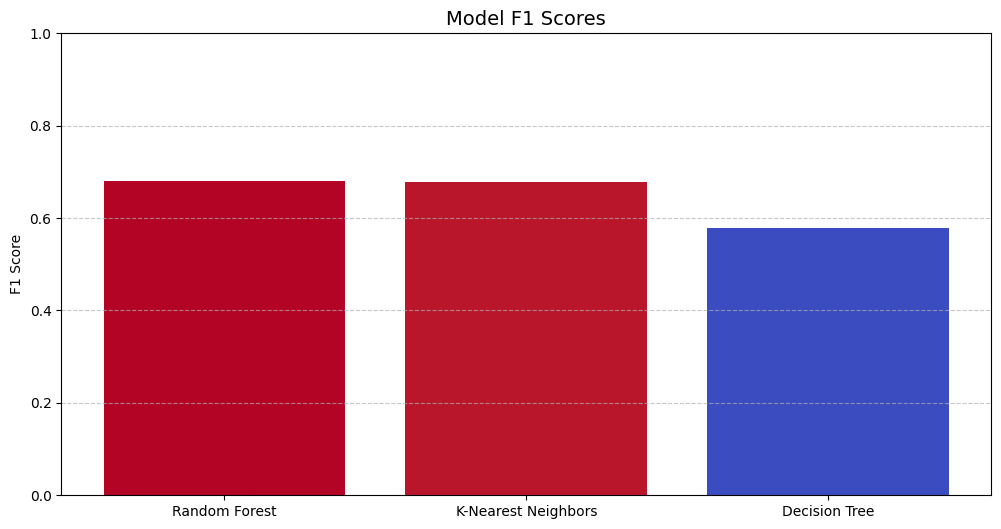

In [13]:
# Visualization of results
model_scores = pd.Series(model_scores
                            ).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(model_scores.index, model_scores,
               color=plt.cm.coolwarm((model_scores - model_scores.min()) /
                                     (model_scores.max() - model_scores.min())))
plt.title('Model F1 Scores', fontsize=14)
plt.ylabel('F1 Score')
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [14]:
print(f'The best model is "{model_scores.idxmax()}" with an F1 score of {model_scores.max()}')

The best model is "Random Forest" with an F1 score of 0.6806382183305906


In [ ]:
# For Debugging: Export data to csv
data = pd.concat([y_train, X_train], axis=1)
data.to_csv('datasets/data.csv', index=False)